## Fune-tune the System -SGD Classifier

#### 0. Import modules and define parameters

In [1]:
import sys
sys.path.append("..")

from module.utils import general_utils
from module.utils import data_prepare_utils
import module.utils.bin_class_utils as bin_class_utils

from sklearn.pipeline import Pipeline
import time
import numpy as np
import pickle

In [2]:
start_time = time.time()

In [ ]:
TRAIN_FILE_PATH = "../data/train_df.csv"
VALIDATION_FILE_PATH = "../data/validation_df.csv"

TARGET_ATTR = "label"
TARGET_TYPE = "binary"

ESTIMATOR_NAME = "SGDClassifier"

SAMPLE_SIZE = 0.05
SAMPLE_RANDOM_STATE = 24
TARGET_ENCODING_RANDOM_STATE = 42
MODEL_RANDOM_STATE = 42
PERMUTATION_IMPORTANCE_RANDOM_STATE = 0

ATTRS_TO_DROP = ['uid', 'app_score', 'his_on_shelf_time', 'task_id', 'spread_app_id', 'tags', 'dev_id']


CVS_SCORING_LIST = ['accuracy', 'precision', 'recall', 'recall', 'f1']
PERMUTATION_SCORING_LIST = ['average_precision', 'roc_auc']

SGD_HYPER_PARAM_GRID = {
    'preprocessor__numerical__imputer__strategy': ['mean', 'median'],
    'preprocessor__categorical__target_encoder__smooth': ['auto'],
#    'estimator__loss': ['log_loss'],
    'estimator__penalty': ['l1', 'l2', 'elasticnet'],
    'estimator__alpha': [0.0001, 0.001, 0.01],
#    'estimator__max_iter': [1000, 10000],
    'estimator__l1_ratio': [0.15, 0.3, 0.5],
    'estimator__n_jobs': [-1],
}

BS_SAMPLE_NUM = 10

#### 1. Import data and identify attributes

In [4]:
train_df = general_utils.read_csv(TRAIN_FILE_PATH)


Read CSV file ../data/train_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1920544,3854,3367,7,207,17,5,11,13,37,...,4,20,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0
1,1850503,3903,6370,7,173,52,5,12,69,11,...,2,-1,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,12,50,7,0
2,2157496,1847,6428,6,178,17,5,18,70,39,...,7,20,1,-1,9,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,7,0
3,2072043,4125,4468,7,168,37,5,12,44,40,...,2,20,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,11,17,6,0
4,1084626,4811,3326,7,183,29,5,12,86,37,...,3,18,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0


df.shape: (670513, 36)


In [5]:
train_df_sample = data_prepare_utils.sample_data(train_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del train_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (33525, 36)


In [6]:
train_cap_x_df, train_y_df = train_df_sample.drop(columns=TARGET_ATTR), train_df_sample[[TARGET_ATTR]]

In [7]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_cap_x_df.columns if attr not in numerical_attr_list and attr != TARGET_ATTR]
attr_list = numerical_attr_list + categorical_attr_list

#### 2. Build composite estimator

In [8]:
preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, ATTRS_TO_DROP, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)

estimator = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)

composite_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('estimator', estimator)
])

composite_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                                         'app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropCol...
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator',
                 SGDClassifier(class_weight='balanced', loss='log_loss',
                               max_iter=10000, random_state=42))])

#### 3. Design grid search and tune hyperparameters of composite estimator

In [9]:
best_model = bin_class_utils.tune_hyperparameters(train_cap_x_df, train_y_df, composite_estimator, SGD_HYPER_PARAM_GRID)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best estimator hyper parameters:
 {'estimator__alpha': 0.01, 'estimator__l1_ratio': 0.15, 'estimator__n_jobs': None, 'estimator__penalty': 'l1', 'preprocessor__categorical__target_encoder__smooth': 'auto', 'preprocessor__numerical__imputer__strategy': 'mean'}


#### 4. Evaluate hyperparameter-tuned estimator on train set

Evaluate the trained estimator performance on train sample set
Check accuracy score
train sample set accuracy score: 0.6824757643549589

Check classification report
              precision    recall  f1-score   support

           0       0.99      0.68      0.81     32369
           1       0.08      0.73      0.14      1156

    accuracy                           0.68     33525
   macro avg       0.53      0.70      0.47     33525
weighted avg       0.95      0.68      0.78     33525


Check confusion matrix
train sample set confusion matrix: 
[[22041 10328]
 [  317   839]]
True Positives =  22041
True Negatives =  839
False Positives(Type I error) =  10328
False Negatives(Type II error) =  317

Check cross validation score

accuracy scores: [0.66308725 0.67964206 0.67815063 0.66845638 0.68844146]
np.mean(scores): 0.6755555555555555
np.std(scores, ddof=1): 0.009941548513155879

precision scores: [0.06443299 0.06212883 0.06303855 0.05654497 0.06632415]
np.mean(scores): 0.0624938961639

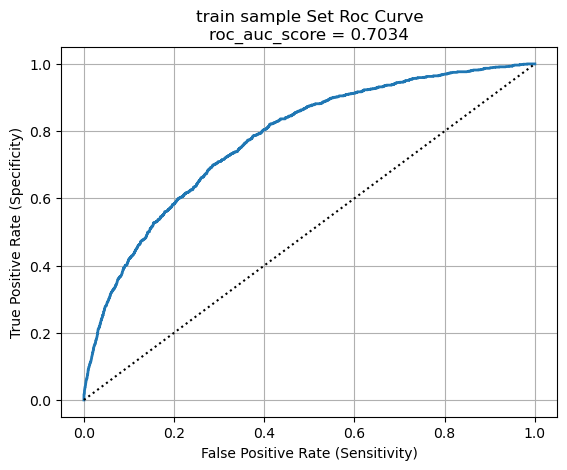


Check Precision-Recall Curve and Average Precision Score


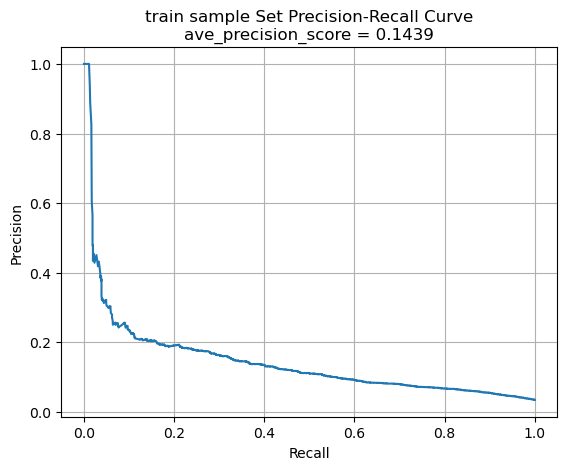

In [10]:
bin_class_utils.eval_class(train_cap_x_df, train_y_df, best_model, "train sample", CVS_SCORING_LIST)

#### 5. Evaluate hyperparameter-tuned estimator on validation set

In [11]:
validation_df = general_utils.read_csv(VALIDATION_FILE_PATH)


Read CSV file ../data/validation_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1451378,2082,3033,7,154,56,5,11,31,40,...,4,20,-1,-1,7,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,17,5,0
1,1619957,1225,4676,7,178,17,5,17,70,39,...,4,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,6,0
2,1698084,2206,2822,7,177,56,5,14,31,40,...,5,20,1,-1,2,-1,-1,17,3,0
3,1983802,5103,2564,7,151,60,4,12,23,26,...,4,20,-1,-1,8,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,39,5,0
4,1537560,1098,1732,7,134,55,4,17,65,18,...,4,20,-1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,12,14,1,0


df.shape: (167629, 36)


In [12]:
validation_df_sample = data_prepare_utils.sample_data(validation_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del validation_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (8381, 36)


In [13]:
validation_cap_x_df, validation_y_df = validation_df_sample.drop(columns=TARGET_ATTR), validation_df_sample[[TARGET_ATTR]]
del validation_df_sample

Evaluate the trained estimator performance on validation sample set
Check accuracy score
validation sample set accuracy score: 0.6743825319174322

Check classification report
              precision    recall  f1-score   support

           0       0.98      0.68      0.80      8092
           1       0.06      0.61      0.11       289

    accuracy                           0.67      8381
   macro avg       0.52      0.64      0.46      8381
weighted avg       0.95      0.67      0.78      8381


Check confusion matrix
validation sample set confusion matrix: 
[[5477 2615]
 [ 114  175]]
True Positives =  5477
True Negatives =  175
False Positives(Type I error) =  2615
False Negatives(Type II error) =  114

Check cross validation score

accuracy scores: [0.61836613 0.63782816 0.65393795 0.68794749 0.65334129]
np.mean(scores): 0.6502842045190939
np.std(scores, ddof=1): 0.0255691975252097

precision scores: [0.0495356  0.06487342 0.05       0.05202312 0.05299145]
np.mean(scores): 0.053884

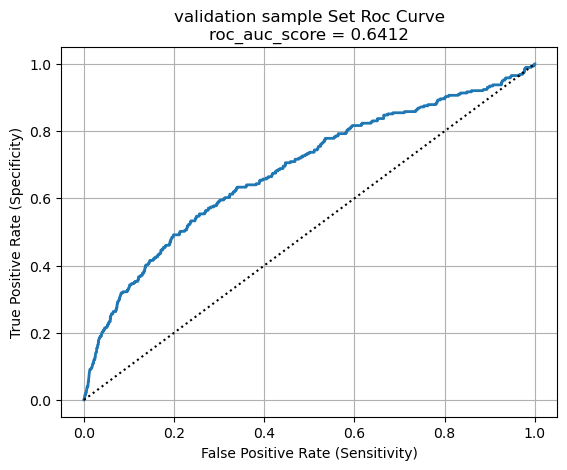


Check Precision-Recall Curve and Average Precision Score


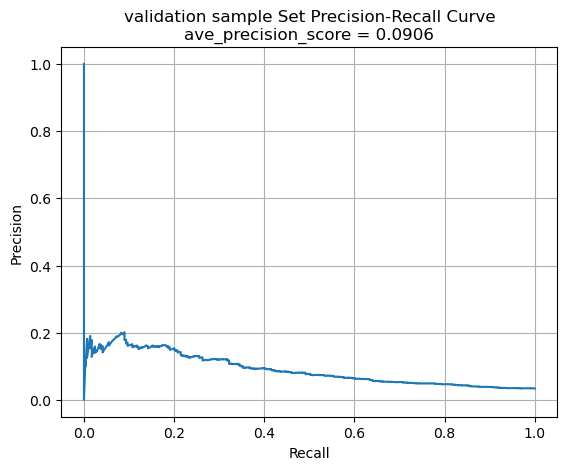

In [14]:
bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, best_model, "validation sample", CVS_SCORING_LIST)

#### 6. Check out permutation feature importance

In [15]:
perm_results_df = bin_class_utils.check_out_permutation_importance(
    best_model, 
    train_cap_x_df, 
    train_y_df, 
    PERMUTATION_IMPORTANCE_RANDOM_STATE,
    PERMUTATION_SCORING_LIST
)
perm_results_df


Check out permutation importance:


,metric_name,feature_name,metric_mean,metric_std_dev
0,average_precision,adv_id,0.073246,0.000994
1,average_precision,slot_id,0.036378,0.004708
2,average_precision,age,0.012775,0.001797
3,roc_auc,adv_id,0.105033,0.003943
4,roc_auc,slot_id,0.049072,0.003651
5,roc_auc,age,0.006474,0.001277
6,roc_auc,adv_prim_id,0.003995,0.001168


#### 7. Check for False Discoveries


**************************************************
means of the distributions:
                          ave_precision_score
distribution                                 
bootstrap_sample                     0.068515
randomized_target_sample             0.036566


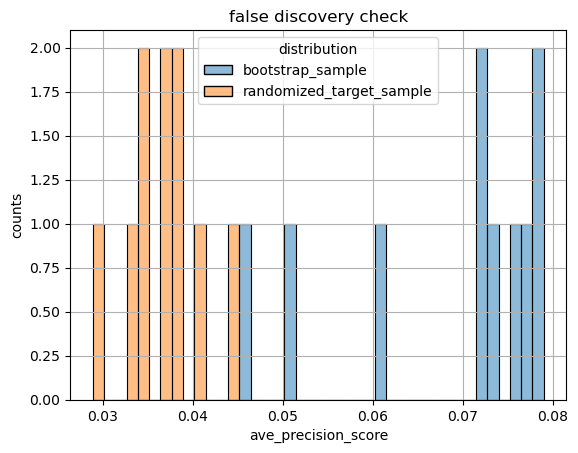


**************************************************
means of the distributions:
                          roc_auc_score
distribution                           
bootstrap_sample               0.652736
randomized_target_sample       0.500560


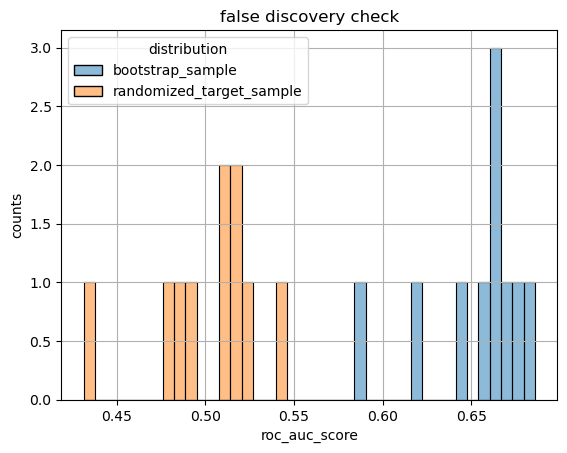

In [16]:
bin_class_utils.avoiding_false_discoveries_class_helper(
    best_model, 
    train_cap_x_df, 
    train_y_df, 
    validation_cap_x_df,
    validation_y_df, 
    num_samples=BS_SAMPLE_NUM
)

#### 8. Tune classification threshold for classification - assess threshold list

In [17]:
thresholds = np.arange(0, 1.1, 0.1)

bin_class_utils.print_classification_metrics_at_thresholds(
    validation_cap_x_df, 
    validation_y_df,
    best_model,  
    thresholds
)


Classification Report at Threshold 0.00:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8092
           1       0.03      1.00      0.07       289

    accuracy                           0.03      8381
   macro avg       0.02      0.50      0.03      8381
weighted avg       0.00      0.03      0.00      8381



C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report at Threshold 0.10:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8092
           1       0.03      1.00      0.07       289

    accuracy                           0.03      8381
   macro avg       0.02      0.50      0.03      8381
weighted avg       0.00      0.03      0.00      8381



C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report at Threshold 0.20:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8092
           1       0.03      1.00      0.07       289

    accuracy                           0.03      8381
   macro avg       0.02      0.50      0.03      8381
weighted avg       0.00      0.03      0.00      8381



C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report at Threshold 0.30:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8092
           1       0.03      1.00      0.07       289

    accuracy                           0.03      8381
   macro avg       0.02      0.50      0.03      8381
weighted avg       0.00      0.03      0.00      8381



C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report at Threshold 0.40:

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      8092
           1       0.03      1.00      0.07       289

    accuracy                           0.03      8381
   macro avg       0.52      0.50      0.03      8381
weighted avg       0.97      0.03      0.00      8381


Classification Report at Threshold 0.50:

              precision    recall  f1-score   support

           0       0.97      0.38      0.54      8092
           1       0.04      0.64      0.07       289

    accuracy                           0.39      8381
   macro avg       0.50      0.51      0.30      8381
weighted avg       0.94      0.39      0.53      8381


Classification Report at Threshold 0.60:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8092
           1       0.00      0.00      0.00       289

    accuracy                           0.97      8381

C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report at Threshold 0.70:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8092
           1       0.00      0.00      0.00       289

    accuracy                           0.97      8381
   macro avg       0.48      0.50      0.49      8381
weighted avg       0.93      0.97      0.95      8381



C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report at Threshold 0.80:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8092
           1       0.00      0.00      0.00       289

    accuracy                           0.97      8381
   macro avg       0.48      0.50      0.49      8381
weighted avg       0.93      0.97      0.95      8381



C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report at Threshold 0.90:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8092
           1       0.00      0.00      0.00       289

    accuracy                           0.97      8381
   macro avg       0.48      0.50      0.49      8381
weighted avg       0.93      0.97      0.95      8381



C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report at Threshold 1.00:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8092
           1       0.00      0.00      0.00       289

    accuracy                           0.97      8381
   macro avg       0.48      0.50      0.49      8381
weighted avg       0.93      0.97      0.95      8381



C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


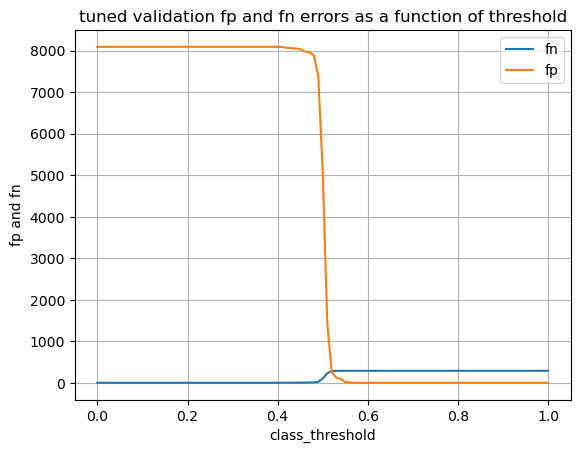

In [18]:
bin_class_utils.plot_errors_to_threshold(
    best_model, 
    validation_cap_x_df, 
    validation_y_df, 
    'tuned validation'
)

#### 9. Higher resolution scan to get the best classification threshold

In [20]:
temp_best_threshold = 0.5

In [21]:
start = temp_best_threshold - 0.05
stop = temp_best_threshold + 0.06
step_size = 0.01

narrow_thresholds = np.arange(start, stop, step_size)
bin_class_utils.print_classification_metrics_at_thresholds(
    validation_cap_x_df, 
    validation_y_df,
    best_model,
    narrow_thresholds
)


Classification Report at Threshold 0.45:

              precision    recall  f1-score   support

           0       0.93      0.01      0.01      8092
           1       0.03      0.99      0.07       289

    accuracy                           0.04      8381
   macro avg       0.48      0.50      0.04      8381
weighted avg       0.90      0.04      0.02      8381


Classification Report at Threshold 0.46:

              precision    recall  f1-score   support

           0       0.95      0.01      0.03      8092
           1       0.03      0.98      0.07       289

    accuracy                           0.05      8381
   macro avg       0.49      0.50      0.05      8381
weighted avg       0.92      0.05      0.03      8381


Classification Report at Threshold 0.47:

              precision    recall  f1-score   support

           0       0.95      0.02      0.03      8092
           1       0.03      0.98      0.07       289

    accuracy                           0.05      8381

In [22]:
best_threshold = 0.5

#### 10. Evaluate the best classification threshold on validation set

Evaluate the trained estimator performance on best validation set
Check accuracy score
best validation set accuracy score: 0.38527622002147716

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.38      0.54      8092
           1       0.04      0.64      0.07       289

    accuracy                           0.39      8381
   macro avg       0.50      0.51      0.30      8381
weighted avg       0.94      0.39      0.53      8381


Check confusion matrix
best validation set confusion matrix: 
[[3043 5049]
 [ 103  186]]
True Positives =  3043
True Negatives =  186
False Positives(Type I error) =  5049
False Negatives(Type II error) =  103

Check cross validation score

accuracy scores: [0.61836613 0.63782816 0.65393795 0.68794749 0.65334129]
np.mean(scores): 0.6502842045190939
np.std(scores, ddof=1): 0.0255691975252097

precision scores: [0.0495356  0.06487342 0.05       0.05202312 0.05299145]
np.mean(scores): 0.05388471916

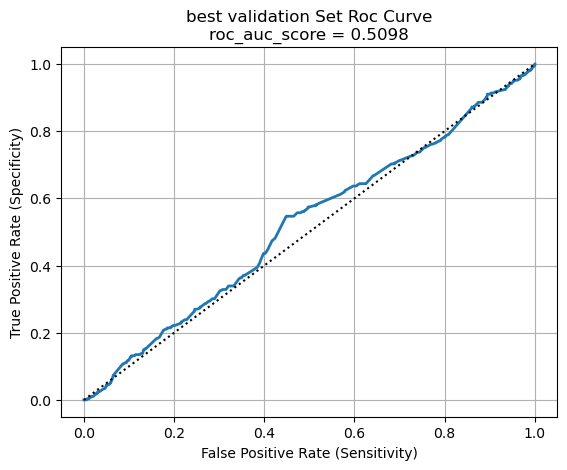


Check Precision-Recall Curve and Average Precision Score


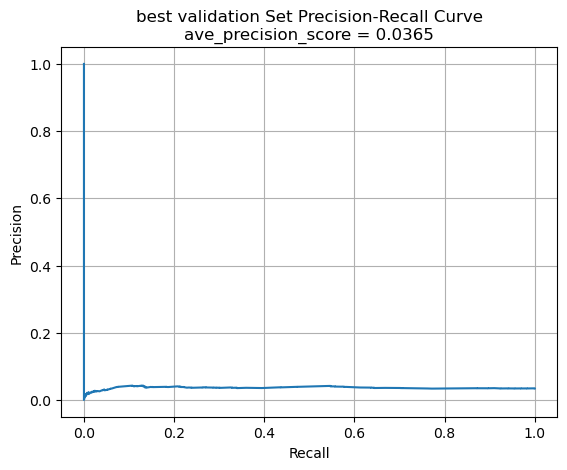

In [23]:
bin_class_utils.eval_class(
    validation_cap_x_df,
    validation_y_df,
    best_model,
    "best validation",
    CVS_SCORING_LIST,
    best_threshold
)

In [ ]:
end_time = time.time()
print(f'Script run time: {(end_time - start_time)/60} minutes')

#### 11. Save the best model with pickle

In [ ]:
#pickle.dump(best_mode, open(ESTIMATOR_NAME + '.pkl', 'wb'))